In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import nltk
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
plt.style.use('fivethirtyeight')
sns.set()
plt.rcParams['figure.figsize'] = (12,12)

In [2]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [3]:
# nltk.download('stopwords')

In [4]:
GRAPH = '../result/Graphs'
TABLE = '../result/Tables'
DATA = '../data'
VERSION = 11  #1: Merged All 2:Cleaned
# os.listdir(DATA)

<h1>Load Pre processed Data</h1>

In [5]:
df = pd.read_csv(os.path.join(DATA,'Dataset_v'+str(VERSION) + '.csv'))
# ONET = pd.read_csv(os.path.join(DATA,'ONET_Occupations.csv'))
ONET = pd.read_csv(os.path.join(DATA,'Information_Technology.csv'))

In [9]:
#Refine some title
def temp_fn(x):
    if 'Software Engineer'.lower() in str(x['JobTitle']).lower(): return 'Software Developers'
    elif 'Software developer'.lower() in str(x['JobTitle']).lower(): return 'Software Developers'
    elif 'Web Developer'.lower() in str(x['JobTitle']).lower(): return 'Web Developers'
    elif 'Executive'.lower() in str(x['JobTitle']).lower() and ('IT' in str(x['JobTitle']) or x['ONET Title'] == 'Computer Occupations, All Other') : return 'Information Technology Project Managers'
    elif 'Assistant'.lower() in str(x['JobTitle']).lower() and ('IT' in str(x['JobTitle']) or x['ONET Title'] == 'Computer Occupations, All Other') : return 'Computer Programmers'
    elif 'Officer'.lower() in str(x['JobTitle']).lower() and 'IT' in str(x['JobTitle']) : return 'Information Technology Project Managers'
    elif 'Manager'.lower() in str(x['JobTitle']).lower() and x['ONET Title'] == 'Computer Occupations, All Other' : return 'Project Management Specialists'
    elif ('Full'.lower() in str(x['JobTitle']).lower() and 'Stack'.lower() in str(x['JobTitle']).lower()) and x['ONET Title'] == 'Computer Occupations, All Other' : return 'Web Developers'
    elif ('Front'.lower() in str(x['JobTitle']).lower() and 'End'.lower() in str(x['JobTitle']).lower()) and x['ONET Title'] == 'Computer Occupations, All Other' : return 'Web and Digital Interface Designers'
    elif 'Head'.lower() in str(x['JobTitle']).lower() and x['ONET Title'] == 'Computer Occupations, All Other' : return 'Business Intelligence Analysts'
    elif 'IT' in str(x['JobTitle']) and x['ONET Title'] == 'Computer Occupations, All Other' : return 'Information Technology Project Managers'
    else : return x['ONET Title']

In [8]:
df['ONET Title'] = None
df['ONET Title'] = df.apply(temp_fn,axis=1)

In [7]:
#Show Some Sample
# df[~df['ONET Title'].isna()][['JobTitle','ONET Title']].sample(20)

In [8]:
#Remove Senior Junior
df['JobTitle'] = df['JobTitle'].str.replace('Senior',' ')
df['JobTitle'] = df['JobTitle'].str.replace('Junior',' ')
df['JobTitle'] = df['JobTitle'].str.replace('Sr.',' ')
df['JobTitle'] = df['JobTitle'].str.replace('Jr.',' ')

<ipython-input-8-bd74d13c395d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['JobTitle'] = df['JobTitle'].str.replace('Sr.',' ')
<ipython-input-8-bd74d13c395d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['JobTitle'] = df['JobTitle'].str.replace('Jr.',' ')


In [14]:
onet_vector_list = []
for occupation in ONET['Occupation'].values:
    onet_vector_list.append(nlp(occupation.lower()).vector)

# Testing

In [174]:
test_data = ['iOS Developer','Java Developer','  App Developer','PHP Developer',\
            'Quality Controller','Android Application Developer', 'Database Administrators',\
            'Software Project Coordinator','Coordinator, Proposals & Knowledge Management',\
             'Project Manager, ERP','Javascript Developer','Database Engineer/ Database Engineer']
ha_vals = ['left','right','right','right','left','center','left','left','left','right','left','left']

#TESTING
from sklearn.decomposition import PCA
pca = PCA(2,whiten=True,random_state=7)
pca.fit(onet_vector_list)
reduced = pca.transform(onet_vector_list)

selected_title = ['Software Quality Assurance Analysts and Testers',\
                 'Database Architects','Software Developers','Web Developers','Project Management Specialists']
fig,ax = plt.subplots()
for i, txt in enumerate(ONET['Occupation'].values):
    if txt in selected_title:
        ax.scatter(reduced[i,0],reduced[i,1],c='tab:blue', s=200)  
        ax.annotate(txt,(reduced[i,0],reduced[i,1]))

        
for i, title in enumerate(test_data):
    
    vector_title = nlp(title).vector
    reduced_vector = pca.transform([vector_title])
#     print(reduced_vector)
    ax.scatter(reduced_vector[0][0],reduced_vector[0][1],c='TAB:PURPLE')
    if title == 'Android Application Developer':
        ax.annotate(title,(reduced_vector[0][0],reduced_vector[0][1]),ha=ha_vals[i],va='bottom')
    elif title == 'iOS Developer' or title == '  App Developer':
        ax.annotate(title,(reduced_vector[0][0],reduced_vector[0][1]),ha=ha_vals[i],va='top')
            
    else:
        ax.annotate(title,(reduced_vector[0][0],reduced_vector[0][1]),ha=ha_vals[i])
                
        
#     list_scores = cosine_similarity(onet_vector_list, vector_title.reshape(1,-1))
#     onet_index = list_scores.argmax()
#     print(title + '..................' + ONET.loc[onet_index,'Occupation'])

In [16]:
occupation_list = []
integer_title = df.JobTitle.str.isnumeric()
refined_title = df[~integer_title]
refined_title = refined_title.JobTitle.values
for title in tqdm(refined_title):
#     title = title.lower()
    vector_title = nlp(title).vector
    list_scores = cosine_similarity(onet_vector_list, vector_title.reshape(1,-1))
    onet_index = list_scores.argmax()
    occupation_list.append(ONET.loc[onet_index,'Occupation'])

100%|██████████| 31525/31525 [02:51<00:00, 183.55it/s]


In [17]:
len(occupation_list) == len(refined_title)

True

In [18]:
integer_title = df.JobTitle.str.isnumeric()
df = df[~integer_title]

In [19]:
df['ONET Title'] = occupation_list

<ipython-input-19-8b051ec3bf80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ONET Title'] = occupation_list


In [21]:
df[['JobTitle','ONET Title']].sample(20)

,JobTitle,ONET Title
5929,Officer - IT,"Computer Occupations, All Other"
28521,Developer/ Programmer,Computer Programmers
15346,Network Infrastructure Chartered Engineer (Par...,Computer Network Support Specialists
29098,Digital File Co-Ordinator & QC,Web and Digital Interface Designers
13946,Software Engineer,Software Developers
17765,Apex Developer,Software Developers
11351,Asst. Manager/ Executive (MICR Operation),Network and Computer Systems Administrators
27313,Staad Pro Software Trainer,Software Developers
26902,Web Developer,Web Developers
8085,Zend Framework Developer (PHP),Web Developers


<h1>Merged Title</h1>

In [10]:
df['MergedTitle'] = df['ONET Title']
df['MergedTitle'] = df['MergedTitle'].replace({
        'Information Technology Project Managers':'Project Management Specialists',
        'Computer Programmers':'Software Developers',
        'Geographic Information Systems Technologists and Technicians':'Computer Occupations, All Other',
        'Health Informatics Specialists':'Computer Occupations, All Other',                        
        })
df['ONET Title'] = df['MergedTitle']

In [27]:
df.to_csv(os.path.join(DATA,'Dataset_v11.csv'),index=False)

<h1>Supply Demand</h1>

In [15]:
df = pd.read_csv(os.path.join(DATA,'Dataset_v11.csv'))

In [16]:
top_title = df['MergedTitle'].value_counts()[:10].index.tolist()
top_title

['Software Developers',
 'Project Management Specialists',
 'Web Developers',
 'Computer Systems Engineers/Architects',
 'Web and Digital Interface Designers',
 'Computer Occupations, All Other',
 'Computer User Support Specialists',
 'Business Intelligence Analysts',
 'Search Marketing Strategists',
 'Network and Computer Systems Administrators']

In [17]:
top_title_df = df[df['ONET Title'].isin(top_title)]
labor_demand_df = top_title_df.groupby(['ONET Title','Year'])['number_applicants'].sum()/top_title_df.groupby(['ONET Title','Year'])['TotalVacancy'].sum()

labor_demand_df  = pd.DataFrame(labor_demand_df).reset_index(drop=False)
labor_demand_df.rename(columns={0:'Demand'},inplace=True)
labor_demand_df = labor_demand_df.pivot(index='ONET Title',columns='Year',values='Demand')
labor_demand_df.to_csv(os.path.join(TABLE,'supply_demand.csv'),float_format='%.3f')
labor_demand_df

Year,2016,2017,2018,2019,2020,2021
ONET Title,,,,,,
Business Intelligence Analysts,221.187342,135.212025,159.721221,207.945368,161.166667,240.608069
"Computer Occupations, All Other",257.664275,216.424280,369.354167,363.147727,329.299505,436.451128
Computer Systems Engineers/Architects,141.301282,117.490925,84.097021,99.749000,88.234201,45.509346
Computer User Support Specialists,141.156137,143.185243,138.138411,217.837178,159.482861,101.256371
Network and Computer Systems Administrators,247.432727,322.491071,230.764085,286.621005,372.588785,360.506024
Project Management Specialists,203.805453,212.187155,186.952670,321.721670,252.503580,208.852518
Search Marketing Strategists,128.366972,82.926606,40.703930,106.050817,140.066038,93.445238
Software Developers,52.951712,55.433507,60.644196,54.913968,51.459953,35.912213
Web Developers,61.964632,59.568702,68.633760,64.686166,50.470909,35.241321


<h1>High Demand Job</h1>

In [18]:
years = list(range(2016,2022))
rank_df = pd.DataFrame(columns =[*years])
for YEAR in years:
    year_df = df[df['Year'] == YEAR]
    top_title = year_df['MergedTitle'].value_counts()[:100].index.tolist()
    for rank,title in enumerate(top_title):
        rank_df.loc[title,YEAR] = rank+1


In [19]:
rank_df.head(15)

,2016,2017,2018,2019,2020,2021
Software Developers,1,1,1,1,1,1
Project Management Specialists,2,2,2,2,3,3
Web Developers,3,3,3,3,2,2
Computer Systems Engineers/Architects,4,7,6,5,4,4
Computer User Support Specialists,5,5,7,7,6,6
"Computer Occupations, All Other",6,6,5,6,5,7
Business Intelligence Analysts,7,8,8,8,8,8
Web and Digital Interface Designers,8,4,4,4,7,5
Network and Computer Systems Administrators,9,9,10,10,11,11
Telecommunications Engineering Specialists,10,12,11,11,10,10


In [20]:
rank_df.head(10).to_csv(os.path.join(TABLE,'title_rank.csv'),float_format='%.3f')

In [21]:
freq = {key: value for key,value in df['MergedTitle'].value_counts().items()}

In [22]:
len(freq)

22

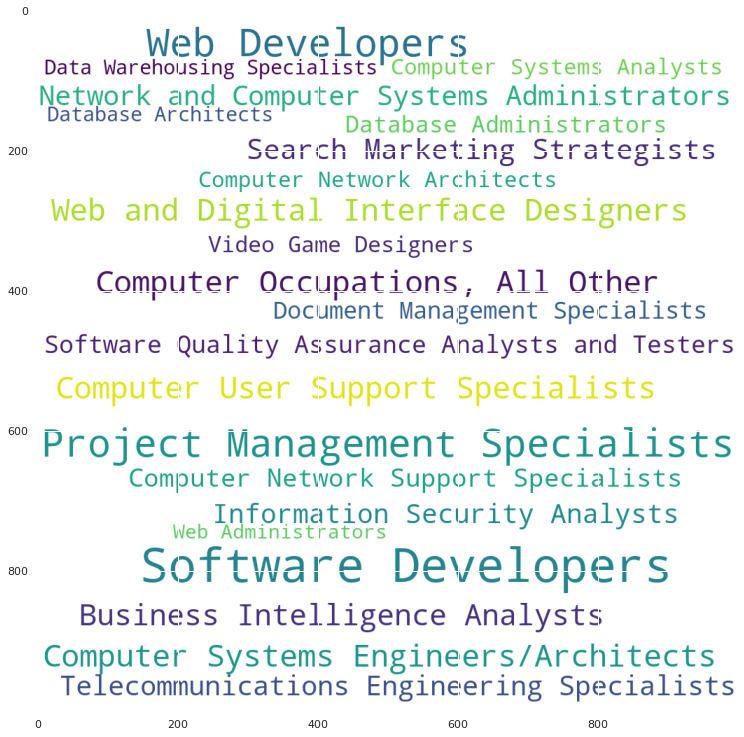

In [24]:
plt.rcParams['figure.figsize']= (12,12)
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.1,normalize_plurals=False).generate_from_frequencies(freq)
plt.imshow(wc)
plt.savefig('WordCloud.png',dpi=350)

<h1>Skill</h1>

In [26]:
df['Job_Responsibility'] = df['Job_Responsibility'].str.replace('Java Script','JavaScript',case=False)
df['Job_Responsibility'].str.contains('Java Script',case=False).sum()

0

In [ ]:
full_context = ' '.join(df['Job_Responsibility'].astype(str).values).upper()
# tokens = TreebankWordTokenizer().tokenize(full_context)


In [110]:
tokens = []
for word in nlp(full_context[:1000]):
    tokens.append(word.lemma_.upper())
tokens

['HAVE',
 'TO',
 'WORK',
 'AT',
 'NIGHT',
 'SHIFT',
 '.',
 'IT',
 'WILL',
 'BE',
 'ROASTER',
 'DUTY',
 'SYSTEM',
 '.',
 ' ',
 'RESPONSIBLE',
 'FOR',
 'THE',
 'PROJECT',
 'IMPLEMENTATION',
 'AND',
 'MAINTAIN',
 'THE',
 'PROJECT',
 'LIFE',
 'CYCLE',
 'DEADLINE',
 '.',
 ' ',
 'PERFORM',
 'THE',
 'DAILY',
 'REGULAR',
 'ALIGNMENT',
 'WITH',
 'THE',
 'PROJECTS',
 'MANAGER',
 '.',
 ' ',
 'PREPARE',
 'DOCUMENTATION',
 'AND',
 'PLAN',
 'FOR',
 'EACH',
 'RESPONSIBLE',
 'PROJECT',
 'AND',
 'VERIFY',
 'WITH',
 'THE',
 'MANAGER',
 '.',
 ' ',
 'IMPLEMENT',
 'CHANGES',
 'AND',
 'MODIFICATION',
 'FOR',
 'PROJECT',
 'AS',
 'AND',
 'WHEN',
 'REQUIRED',
 '.',
 ' ',
 'ALIGNMENT',
 'WITH',
 'THE',
 'OPERATION',
 'AND',
 'PERFORMANCE',
 'FUNCTION',
 'WITH',
 'NECESSARY',
 'INFORMATION',
 '.',
 ' ',
 'ATTEND',
 'THE',
 'REGULAR',
 'FORUM',
 'AND',
 'MEETING',
 'AND',
 'SEND',
 'THE',
 'RIGHT',
 'FEEDBACK',
 '.',
 ' ',
 'UNDERSTAND',
 'THE',
 'ENTERPRISE',
 'AND',
 'PROFESSIONAL',
 'LEVEL',
 'PROJECT',
 'AND'

In [87]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words = [words.upper() for words in stop_words]
tokens = [t for t in tokens if t not in stop_words]

In [88]:
counter = Counter(tokens)

In [89]:
counter.most_common(1000)

[(',', 222506),
 ('&', 30910),
 ('DESIGN', 21435),
 (')', 20120),
 ('(', 19909),
 ('SOFTWARE', 19403),
 ('KNOWLEDGE', 18835),
 ('DEVELOPMENT', 18229),
 ('EXPERIENCE', 18118),
 (';', 16487),
 ('WORK', 15213),
 ('TEAM', 13605),
 ('DEVELOP', 13352),
 ('WEB', 13218),
 ('SUPPORT', 12905),
 ('ENSURE', 12369),
 ('MAINTAIN', 12162),
 ('NEW', 11606),
 ('SYSTEM', 11272),
 ('DATA', 11212),
 ('NETWORK', 10580),
 ('MUST', 10492),
 ('TECHNICAL', 10376),
 ('MANAGEMENT', 10051),
 ('BUSINESS', 9768),
 ('PROJECT', 9465),
 ('APPLICATION', 8987),
 ('#', 8919),
 ('SYSTEMS', 8184),
 ('USING', 8056),
 ('PROVIDE', 8006),
 ('GOOD', 7922),
 ('ETC.', 7862),
 ('CODE', 7580),
 ('APPLICATIONS', 7513),
 ('SERVER', 7496),
 ('REQUIREMENTS', 7385),
 ('TEST', 7285),
 ('WORKING', 7146),
 ('UNDERSTANDING', 7000),
 ('DATABASE', 6994),
 ('STRONG', 6736),
 ('MANAGE', 6617),
 ('PERFORMANCE', 6523),
 (':', 6287),
 ('USER', 6221),
 ('MARKETING', 6121),
 ('PRODUCT', 6110),
 ('SECURITY', 5967),
 ('TESTING', 5892),
 ('HARDWARE', 5

In [117]:
import collections
import re
import sys
import time


def tokenize(string):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    return re.findall(r'\w+', string.lower())


def count_ngrams(lines, min_length=3, max_length=3):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams


def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-grams -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')


In [118]:
params = [txt for txt in df['Job_Responsibility'].astype(str).values]
ngrams = count_ngrams(params)

In [119]:
print_most_frequent(ngrams,1000)

----- 1000 most common 3-grams -----
be able to: 1829
as well as: 1567
up to date: 1203
assigned by the: 1197
design and develop: 1160
ability to work: 1117
work closely with: 1098
must have experience: 1082
in order to: 1052
hardware and software: 1049
day to day: 1023
by the management: 1020
good understanding of: 1003
and maintenance of: 998
strong knowledge of: 919
must have good: 911
able to work: 887
have good knowledge: 880
have experience in: 874
must be able: 808
be responsible for: 804
we are looking: 797
hands on experience: 795
good knowledge in: 781
is a plus: 762
are looking for: 754
of the company: 752
to work with: 745
good knowledge of: 720
good knowledge on: 716
will be responsible: 708
object oriented programming: 699
development life cycle: 690
you will be: 682
as and when: 669
develop and maintain: 667
asp net mvc: 665
and best practices: 656
team members and: 651
the company s: 649
with team members: 632
to work in: 589
work under pressure: 584
to work on: 581
to 

<h1> Group Skills </h1>

In [111]:
skills_dict = {'Database': ['DATABASE','DATABASES','DATABASE.',],
            'Networking':['SERVER','SERVERS','NETWORKING','LAN','ROUTER','WAN','WI FI',\
                          'FIREWALL','ROUTING','WIRELESS','VPN','DNS','SERVER.','ROUTERS','NETWORK SECURITY'],
             'Testing & QA':['TESTING','QA','TESTING.', 'QUALITY ASSURANCE','UNIT TEST'],
             'Java':['JAVA'],
             'PHP':['PHP'],
             'JavaScript':['JAVASCRIPT','JS'],
             'API': ['API','APIS','APIS.'],
             'SQL':['SQL'],
             'jQuery':['JQUERY'],
             'WordPress':['WORDPRESS'],
            'Research': ['RESEARCH'],
             'CSS':['CSS','CSS3',],
             'HTML': ['HTML','HTML5',],
             'Ajax': ['AJAX',],
             'C': ['C'],
             'Laravel': ['LARAVEL',],
             'iOS':['IOS'],
             'ASP.NET': ['ASP.NET','.NET','ASP NET'],
             'Git': ['GIT','VERSION CONTROL'],
            'Cloud':['CLOUD'],
             'Agile': ['AGILE'],
             'OOP': ['OOP','OBJECT-ORIENTED','OBJECT ORIENTED'],
             'Angular': ['ANGULAR','ANGULARJS','ANGULAR JS'],
             'Debugging': ['TROUBLESHOOTING','DEBUGGING','DEBUG','BUG FIXING'],
              'Photoshop': ['PHOTOSHOP'],
             'Illustrator': ['ILLUSTRATOR'],
             'Python': ['PYTHON'],
             'aws': ['AWS'],
             'Marketing': ['MARKETING','MARKETING.'],
              'Andriod': ['ANDROID'],
              'SEO': ['SEO'],
              'MySQL': ['MYSQL'],
              'Oracle': ['ORACLE'],
              'ERP': ['ERP'],
              'MVC': ['MVC'],
              'UI Design': ['UI','FRONT-END','GRAPHICS','UI/UX','UX','FRONT END'],
              'Linux': ['LINUX'],
              'BootStrap': ['BOOTSTRAP'],
              'React': ['REACT'],
              'Spring': ['SPRING'],
              'Documentation' : ['DOCUMENTATION','DOCUMENTATION.'],
              'CCTV':['CCTV', 'CAMERA'],
               'C#':['C#']
          
          
             }

In [171]:
skills_df = pd.DataFrame(index=df.index,columns= skills_dict.keys()).fillna(0)
skills_df.loc[:,'NodeJS'] = 0
skills_df.loc[:,'SQL Server'] = 0
skills_df.loc[:,'Design Pattern'] = 0

In [172]:
for i,context in enumerate(df['Job_Responsibility'].astype(str).values):
    context = context.upper()
    tokens = TreebankWordTokenizer().tokenize(str(context).upper())
    for key, values in skills_dict.items():
        for value in values:
            if value in tokens:
                skills_df.loc[i,key] = 1
    
    if 'C#' in context:
        skills_df.loc[i,'C#'] = 1
        if 'C' in tokens and '#' in tokens:
            skills_df.loc[i,'C'] = 0
    if 'NODE JS' in context:
        skills_df.loc[i,'NodeJS'] = 1
        
    if 'SQL' in tokens:
        skills_df.loc[i,'SQL'] = tokens.count('SQL')
    if 'SQL SERVER' in context or 'MS SQL' in context:
        skills_df.loc[i,'SQL Server'] = 1
    skills_df.loc[i,'SQL'] -= skills_df.loc[i,'SQL Server']
    if skills_df.loc[i,'SQL'] > 0:
        skills_df.loc[i,'SQL'] = 1
    else:
        skills_df.loc[i,'SQL'] = 0
        
    if 'DESIGN PATTERNS' in context or 'DESIGN PATTERN' in context:
        skills_df.loc[i,'Design Pattern'] = 1
               

In [173]:
skills_df['Year'] = df['Year']
skills_df['Title'] = df['ONET Title']

In [174]:
skills_df

,Database,Networking,Testing & QA,Java,PHP,JavaScript,API,SQL,jQuery,WordPress,...,React,Spring,Documentation,CCTV,C#,NodeJS,SQL Server,Design Pattern,Year,Title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2018,Software Developers
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,2018,Software Developers
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2018,Project Management Specialists
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2018,Project Management Specialists
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2018,Network and Computer Systems Administrators
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,Computer Systems Engineers/Architects
31521,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2021,Web and Digital Interface Designers
31522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,"Computer Occupations, All Other"
31523,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,Computer Systems Engineers/Architects


In [175]:
skills_df.to_csv('Skills_df.csv')


In [176]:
skills_df = pd.read_csv('Skills_df.csv')
skills_df.drop('Unnamed: 0',inplace=True,axis=1)

In [139]:
required_title = ['Software Developers','Web Developers','Web and Digital Interface Designers',\
                 'Search Marketing Strategists','Network and Computer Systems Administrators','Database Administrators',\
                 'Database Architects','Information Security Analysts']

In [177]:
skills_df = skills_df[skills_df['Title'].isin(required_title)]

In [178]:
yrlen = skills_df.groupby('Year').count().iloc[:,0]

In [179]:
skills_df = skills_df.groupby('Year').sum().T


In [180]:
skill_final_df = pd.DataFrame(index=skills_df.index, columns = pd.MultiIndex.from_product([range(2016,2022),['Rank','Percentage']]))

In [181]:
for col in range(2016,2022):
    temp = skills_df[col].sort_values(ascending=False) / yrlen[col] * 100

    dictionary = {}
    percentage = {}
    for i,idx in enumerate(temp.index):
        dictionary[idx] = i + 1
        percentage[idx] = temp[idx]
    skill_final_df[(col,'Rank')] = skill_final_df.index.map(dictionary)
    skill_final_df[(col,'Percentage')] = skill_final_df.index.map(percentage)    

In [182]:
skill_final_df

2016            2017            2018            2019  \
               Rank Percentage Rank Percentage Rank Percentage Rank   
Database          5  21.077844    2  20.554100    1  19.318996    1   
Networking        4  21.197605    4  18.906776    4  16.451613    5   
Testing & QA     11  12.495010   10  14.114564   11  11.003584   11   
Java             23   8.023952   27   6.252340   23   6.702509   28   
PHP               2  21.836327    3  20.029951    5  16.415771    6   
JavaScript        1  22.994012    1  22.575814    2  19.139785    2   
API              14  11.976048    9  14.189442    8  14.802867    4   
SQL              19   9.620758   17   8.873081   16   8.960573   16   
jQuery            7  18.203593    8  16.697866   10  12.114695   10   
WordPress        18   9.820359   22   7.675028   21   7.275986   30   
Research         32   4.870259   26   6.851367   17   7.992832   19   
CSS               6  20.678643    6  18.457507    7  15.089606    8   
HTML              3  21.437126    5  18.719581    6  15.734767    7   
Ajax             13  12.255489   14  11.306627   15   9.390681   20   
C                43   1.277445   44   1.198053   45   1.003584   46   
Laravel          33   4.590818   30   5.653313   20   7.347670   17   
iOS              28   6.107784   32   5.353800   32   4.731183   36   
ASP.NET          12  12.375250   16   9.921378   24   6.702509   21   
Git              36   3.992016   28   5.952827   30   5.519713   23   
Cloud            39   2.594810   39   2.470985   39   3.046595   39   
Agile            35   4.111776   38   4.080869   37   3.512545   33   
OOP              22   8.263473   20   8.199176   26   6.379928   15   
Angular          26   6.506986   24   7.525271   22   6.810036   25   
Debugging        16  10.179641   13  11.755897   13  10.322581   13   
Photoshop        29   6.027944   29   5.840509   29   5.627240   29   
Illustrator      34   4.271457   37   4.155747   33   4.157706   34   
Python           41   1.676647   41   1.871958   42   1.863799   41   
aws              44   0.878244   45   1.048297   43   1.577061   44   
Marketing        27   6.307385   19   8.236615   12  11.003584   12   
Andriod          21   8.303393   21   8.086859   19   7.706093   22   
SEO              37   3.912176   35   4.567578   27   6.308244   26   
MySQL             9  13.852295   12  12.317484   14   9.677419   14   
Oracle           25   6.706587   34   4.979408   35   3.727599   35   
ERP              38   3.433134   36   4.342943   38   3.046595   40   
MVC              15  11.017964   15   9.958817   18   7.777778   18   
UI Design         8  16.526946    7  16.997379    3  18.315412    3   
Linux            31   4.870259   31   5.540996   34   3.942652   37   
BootStrap        17   9.980040   18   8.461250   25   6.487455   24   
React            45   0.479042   43   1.272931   40   2.473118   38   
Spring           40   1.796407   42   1.535006   44   1.505376   42   
Documentation    10  12.774451   11  12.654437    9  12.114695    9   
CCTV             42   1.596806   40   1.984276   41   2.222222   43   
C#               24   7.864271   25   7.225758   31   5.519713   32   
NodeJS           46   0.279441   46   0.374392   46   0.645161   45   
SQL Server       20   9.341317   23   7.637589   28   5.770609   31   
Design Pattern   30   4.990020   33   5.278922   36   3.655914   27   

                          2020            2021             
               Percentage Rank Percentage Rank Percentage  
Database        21.868583    1  25.185833    2  25.100216  
Networking      18.446270    7  17.271535    5  18.994758  
Testing & QA    12.491444    9  14.954088    6  17.144619  
Java             6.125941   27   6.777438   30   6.506321  
PHP             16.187543    8  17.184084   10  13.660191  
JavaScript      21.081451    3  23.830345    4  20.906568  
API             19.472964    2  25.054657    1  26.672834  
SQL              9.103354   25   7.826847   18   9.312365  
jQuery

In [183]:
skill_final_df.to_csv('skills_full_csv.csv')

In [184]:
skill_final_df.iloc[:, skill_final_df.columns.get_level_values(1)=='Rank'].to_csv('skill_rank_df.csv')


In [287]:
plt.rcParams['figure.figsize']= (12,12)
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.1,normalize_plurals=False).generate_from_frequencies(skills_df.sum(axis=1))
plt.imshow(wc)
plt.savefig('../graph/SkillWordCloud.png',dpi=350)

TypeError: argument of type 'int' is not iterable

# Correlation Analysis


In [303]:
skills_df = pd.read_csv('Skills_df.csv')
skills_df.drop('Unnamed: 0',inplace=True,axis=1)
skills_df = skills_df.fillna(0)

In [293]:
selected_skills = ['JavaScript','CSS','HTML','Ajax','jQuery','Laravel','Photoshop','Illustrator','ASP.NET',\
                  'MySQL','BootStrap','C#','SQL Server','Marketing','SEO','Java','Spring','OOP','Design Pattern']

In [294]:
skills_corr_df = skills_df.drop(['Year','Title'],axis=1)

In [295]:
skills_corr_df = skills_corr_df[selected_skills]

In [296]:
import itertools
from sklearn.metrics import cohen_kappa_score
data = pd.DataFrame(index=skills_corr_df.columns,columns=skills_corr_df.columns).fillna(0)
# # Calculate cohen_kappa_score for every combination of raters
# # Combinations are only calculated j -> k, but not k -> j, which are equal
# # So not all places in the matrix are filled.
for j, k in list(itertools.combinations(skills_corr_df.columns, r=2)):
#     print(j,k)
    data.loc[k, j] = cohen_kappa_score(skills_corr_df[j], skills_corr_df[k])

In [297]:
data

,JavaScript,CSS,HTML,Ajax,jQuery,Laravel,Photoshop,Illustrator,ASP.NET,MySQL,BootStrap,C#,SQL Server,Marketing,SEO,Java,Spring,OOP,Design Pattern
JavaScript,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
CSS,0.628803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
HTML,0.606702,0.804509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Ajax,0.458301,0.412571,0.363524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
jQuery,0.590382,0.566585,0.504679,0.598476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Laravel,0.292075,0.256222,0.223804,0.321859,0.296603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Photoshop,0.052186,0.104024,0.105841,0.042509,0.069164,-0.014609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Illustrator,0.036267,0.080361,0.079018,0.028252,0.055823,-0.011959,0.778988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
ASP.NET,0.192354,0.174873,0.194303,0.173545,0.231801,-0.021051,-0.028500,-0.021008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
MySQL,0.385193,0.357416,0.298442,0.393572,0.392464,0.367928,0.013612,0.011459,0.018688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


<ipython-input-299-4f199a7b8275>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data,dtype=np.bool)


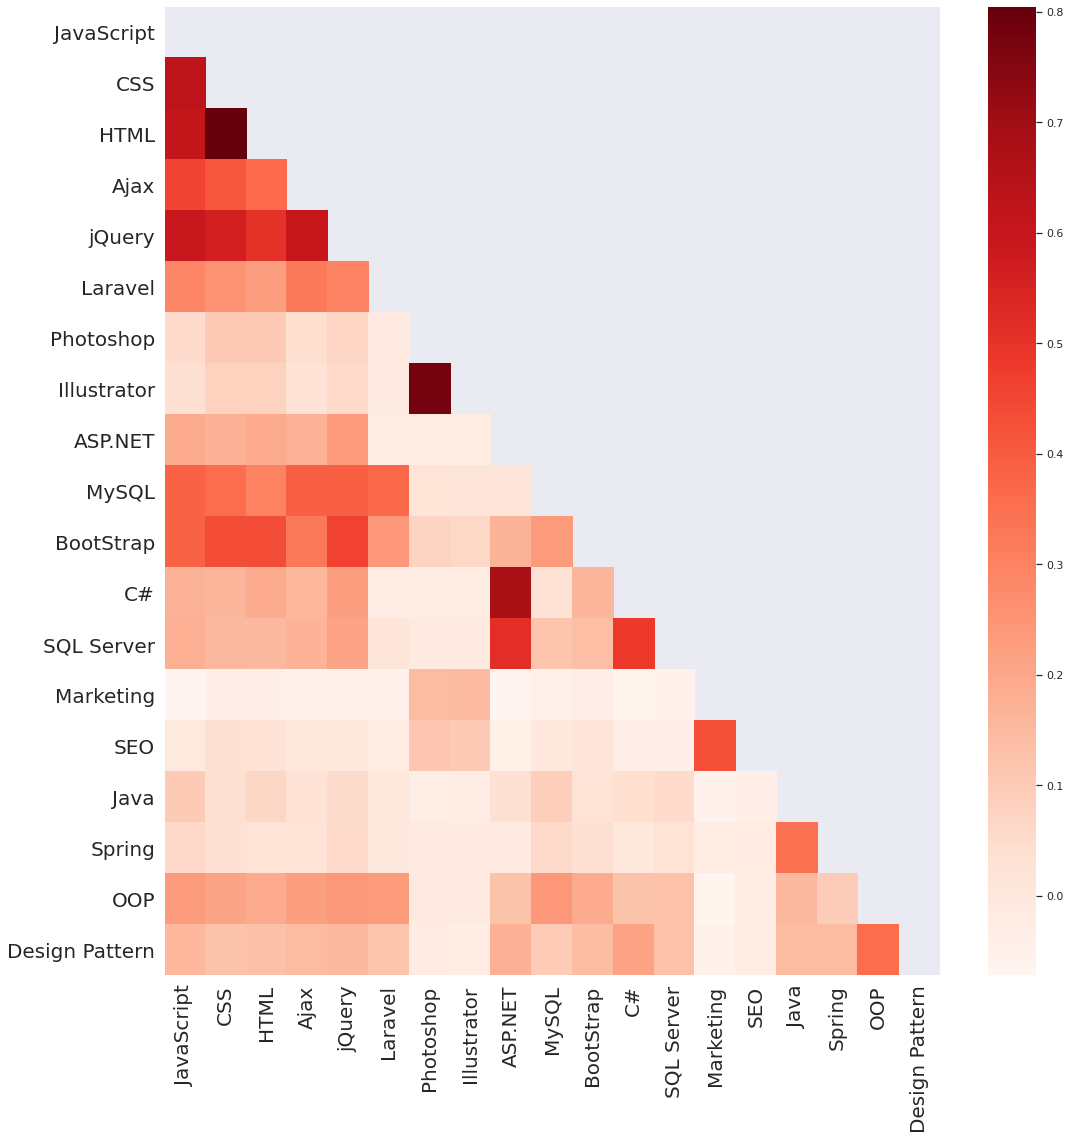

In [299]:
mask = np.zeros_like(data,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['figure.figsize'] = (16,16)
ax = sns.heatmap(data,mask=mask,cmap='Reds')
cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('../graph/SKill_heatmap_min.png',dpi=350)

In [304]:
skills_corr_df = skills_df.drop(['Year'],axis=1)
job_skill_corr = skills_corr_df.join(pd.get_dummies(skills_corr_df['Title']))
job_skill_corr = job_skill_corr.drop(['Title'],axis=1)

job_skill_corr

,Database,Networking,Testing & QA,Java,PHP,JavaScript,API,SQL,jQuery,WordPress,...,Network and Computer Systems Administrators,Project Management Specialists,Search Marketing Strategists,Software Developers,Software Quality Assurance Analysts and Testers,Telecommunications Engineering Specialists,Video Game Designers,Web Administrators,Web Developers,Web and Digital Interface Designers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31521,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
31522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31523,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [264]:
job_skill_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31525 entries, 0 to 31524
Data columns (total 68 columns):
 #   Column                                           Non-Null Count  Dtype
---  ------                                           --------------  -----
 0   Database                                         31525 non-null  int64
 1   Networking                                       31525 non-null  int64
 2   Testing & QA                                     31525 non-null  int64
 3   Java                                             31525 non-null  int64
 4   PHP                                              31525 non-null  int64
 5   JavaScript                                       31525 non-null  int64
 6   API                                              31525 non-null  int64
 7   SQL                                              31525 non-null  int64
 8   jQuery                                           31525 non-null  int64
 9   WordPress                                        3

In [305]:
import itertools
from sklearn.metrics import cohen_kappa_score
data = pd.DataFrame(index=job_skill_corr.columns,columns=job_skill_corr.columns).fillna(0)
# # Calculate cohen_kappa_score for every combination of raters
# # Combinations are only calculated j -> k, but not k -> j, which are equal
# # So not all places in the matrix are filled.
for j, k in list(itertools.combinations(job_skill_corr.columns, r=2)):
#     print(j,k)
    data.loc[k, j] = cohen_kappa_score(job_skill_corr[j], job_skill_corr[k])

In [306]:
data = data.iloc[46:,:46]

In [307]:
required_title = ['Software Developers','Web Developers',\
                  'Web and Digital Interface Designers','Search Marketing Strategists']
data = data.loc[required_title,:]

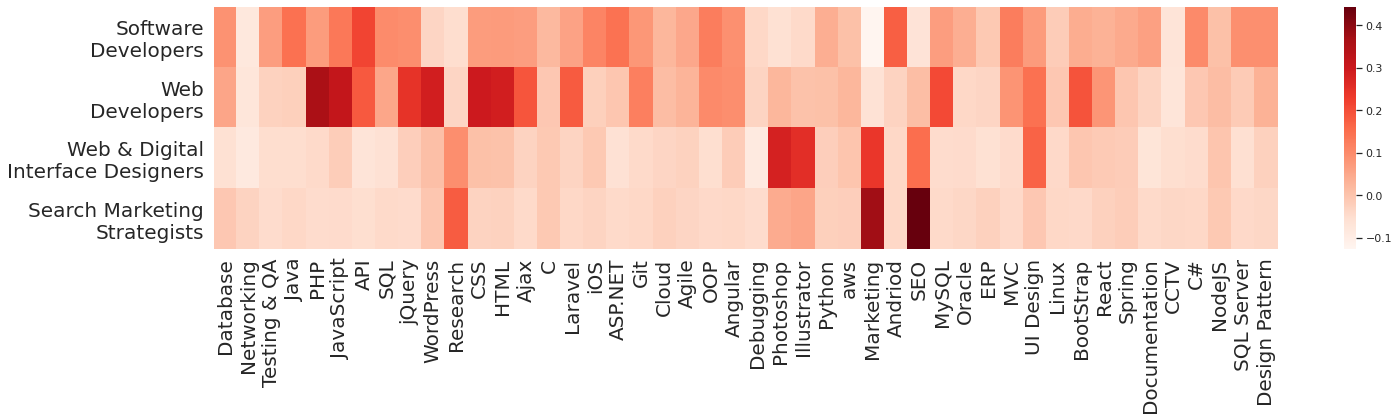

In [308]:
# mask = np.zeros_like(corr_df,dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

plt.rcParams['figure.figsize'] = (24,6)
ax = sns.heatmap(data,cmap='Reds')
cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
ax.set_yticklabels(['Software\nDevelopers','Web\nDevelopers','Web & Digital\nInterface Designers','Search Marketing\nStrategists'])
plt.savefig('../graph/Skill_Title_Corr_min.png',dpi=350)